In [5]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [8]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [9]:
df = load_csv()

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

In [117]:
# Isolating data and species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [110]:
from imblearn.under_sampling import RandomUnderSampler

# Perform undersampling on majority class

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)


In [16]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [118]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        return

In [111]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

# Create neural network model
def createModel():
    model = Sequential()

    model.add(Dense(units=22, activation='relu', input_dim=22))
    model.add(Dense(units=32, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [119]:
from sklearn.metrics import classification_report

N_EPOCHS = 100
BATCH_SIZE = 32

metrics = []

def trainAndTestModel(model, x_train, y_train, x_val, y_val):
    
    # Where the current iteration's extra metrics will be stored
    metrics.append(Metrics())
    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, callbacks=[metrics[-1]])
    
    pred = model.predict(x_val, batch_size=32, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    
    report = classification_report(argmax(y_val, axis=1), y_pred)
    
    mFeature = metricsByFeature(argmax(y_val, axis=1), y_pred)
    featuresMetrics.append(mFeature)
    
    print(report)
    
    return history 

In [112]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

def metricsByFeature(y_true, y_pred):
        metricsSummary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
        
        finalMetrics = {
            'precision': metricsSummary[0],
            'recall': metricsSummary[1],
            'f1-score': metricsSummary[2],
            'support': metricsSummary[3]
        }
        
        return finalMetrics

In [120]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

historyList = []
featuresMetrics = []
metrics = []

# Actually train as test the model
for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = trainAndTestModel(model, xtrain, ytrain, xval, yval)
    
    historyList.append(history)
    

Train on 3866 samples, validate on 972 samples
Epoch 1/100
3866/3866 [==============================] - 1s 388us/step - loss: 2.2133 - acc: 0.2183 - val_loss: 2.1139 - val_acc: 0.2603
Epoch 2/100
1152/3866 [=======>......................] - ETA: 0s - loss: 2.1022 - acc: 0.2630

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3866/3866 [==============================] - 1s 178us/step - loss: 2.0374 - acc: 0.2597 - val_loss: 1.9607 - val_acc: 0.2387
Epoch 3/100
3866/3866 [==============================] - 1s 151us/step - loss: 1.8979 - acc: 0.2491 - val_loss: 1.8358 - val_acc: 0.3220
Epoch 4/100
3866/3866 [==============================] - 0s 80us/step - loss: 1.7777 - acc: 0.3733 - val_loss: 1.7186 - val_acc: 0.4455
Epoch 5/100
3866/3866 [==============================] - 0s 101us/step - loss: 1.6599 - acc: 0.4710 - val_loss: 1.6032 - val_acc: 0.5267
Epoch 6/100
3866/3866 [==============================] - 0s 63us/step - loss: 1.5460 - acc: 0.5481 - val_loss: 1.4962 - val_acc: 0.5730
Epoch 7/100
3866/3866 [==============================] - 0s 68us/step - loss: 1.4420 - acc: 0.6148 - val_loss: 1.3999 - val_acc: 0.6276
Epoch 8/100
3866/3866 [==============================] - 0s 57us/step - loss: 1.3481 - acc: 0.6495 - val_loss: 1.3127 - val_acc: 0.6574
Epoch 9/100
3866/3866 [==============================] - 

Epoch 62/100
3866/3866 [==============================] - 0s 68us/step - loss: 0.2738 - acc: 0.9315 - val_loss: 0.3323 - val_acc: 0.9198
Epoch 63/100
3866/3866 [==============================] - 0s 76us/step - loss: 0.2706 - acc: 0.9338 - val_loss: 0.3281 - val_acc: 0.9239
Epoch 64/100
3866/3866 [==============================] - 0s 59us/step - loss: 0.2687 - acc: 0.9338 - val_loss: 0.3271 - val_acc: 0.9198
Epoch 65/100
3866/3866 [==============================] - 0s 58us/step - loss: 0.2658 - acc: 0.9333 - val_loss: 0.3235 - val_acc: 0.9270
Epoch 66/100
3866/3866 [==============================] - 0s 58us/step - loss: 0.2643 - acc: 0.9356 - val_loss: 0.3255 - val_acc: 0.9249
Epoch 67/100
3866/3866 [==============================] - 0s 58us/step - loss: 0.2620 - acc: 0.9348 - val_loss: 0.3198 - val_acc: 0.9270
Epoch 68/100
3866/3866 [==============================] - 0s 63us/step - loss: 0.2599 - acc: 0.9366 - val_loss: 0.3181 - val_acc: 0.9249
Epoch 69/100
3866/3866 [=================

Epoch 17/100
3868/3868 [==============================] - 0s 61us/step - loss: 0.8251 - acc: 0.7516 - val_loss: 0.7833 - val_acc: 0.7526
Epoch 18/100
3868/3868 [==============================] - 0s 62us/step - loss: 0.7914 - acc: 0.7531 - val_loss: 0.7515 - val_acc: 0.7680
Epoch 19/100
3868/3868 [==============================] - 0s 63us/step - loss: 0.7614 - acc: 0.7578 - val_loss: 0.7216 - val_acc: 0.7691
Epoch 20/100
3868/3868 [==============================] - 0s 65us/step - loss: 0.7336 - acc: 0.7640 - val_loss: 0.6956 - val_acc: 0.7711
Epoch 21/100
3868/3868 [==============================] - 0s 62us/step - loss: 0.7087 - acc: 0.7702 - val_loss: 0.6683 - val_acc: 0.7742
Epoch 22/100
3868/3868 [==============================] - 0s 62us/step - loss: 0.6851 - acc: 0.7766 - val_loss: 0.6458 - val_acc: 0.7814
Epoch 23/100
3868/3868 [==============================] - 0s 77us/step - loss: 0.6633 - acc: 0.7810 - val_loss: 0.6241 - val_acc: 0.7969
Epoch 24/100
3868/3868 [=================

Epoch 77/100
3868/3868 [==============================] - 0s 61us/step - loss: 0.2756 - acc: 0.9253 - val_loss: 0.2596 - val_acc: 0.9299
Epoch 78/100
3868/3868 [==============================] - 0s 65us/step - loss: 0.2738 - acc: 0.9255 - val_loss: 0.2537 - val_acc: 0.9371
Epoch 79/100
3868/3868 [==============================] - 0s 71us/step - loss: 0.2716 - acc: 0.9255 - val_loss: 0.2558 - val_acc: 0.9392
Epoch 80/100
3868/3868 [==============================] - 0s 64us/step - loss: 0.2698 - acc: 0.9274 - val_loss: 0.2502 - val_acc: 0.9412
Epoch 81/100
3868/3868 [==============================] - 0s 61us/step - loss: 0.2677 - acc: 0.9279 - val_loss: 0.2527 - val_acc: 0.9340
Epoch 82/100
3868/3868 [==============================] - 0s 62us/step - loss: 0.2659 - acc: 0.9276 - val_loss: 0.2489 - val_acc: 0.9340
Epoch 83/100
3868/3868 [==============================] - 0s 64us/step - loss: 0.2639 - acc: 0.9276 - val_loss: 0.2454 - val_acc: 0.9412
Epoch 84/100
3868/3868 [=================

Epoch 32/100
3871/3871 [==============================] - 0s 59us/step - loss: 0.4834 - acc: 0.8690 - val_loss: 0.4706 - val_acc: 0.8718
Epoch 33/100
3871/3871 [==============================] - 0s 59us/step - loss: 0.4705 - acc: 0.8752 - val_loss: 0.4586 - val_acc: 0.8728
Epoch 34/100
3871/3871 [==============================] - 0s 61us/step - loss: 0.4586 - acc: 0.8765 - val_loss: 0.4475 - val_acc: 0.8769
Epoch 35/100
3871/3871 [==============================] - 0s 62us/step - loss: 0.4479 - acc: 0.8822 - val_loss: 0.4364 - val_acc: 0.8800
Epoch 36/100
3871/3871 [==============================] - 0s 61us/step - loss: 0.4367 - acc: 0.8843 - val_loss: 0.4253 - val_acc: 0.8842
Epoch 37/100
3871/3871 [==============================] - 0s 60us/step - loss: 0.4272 - acc: 0.8863 - val_loss: 0.4198 - val_acc: 0.8800
Epoch 38/100
3871/3871 [==============================] - 0s 66us/step - loss: 0.4181 - acc: 0.8871 - val_loss: 0.4070 - val_acc: 0.8883
Epoch 39/100
3871/3871 [=================

Epoch 92/100
3871/3871 [==============================] - 0s 62us/step - loss: 0.2402 - acc: 0.9421 - val_loss: 0.2516 - val_acc: 0.9307
Epoch 93/100
3871/3871 [==============================] - 0s 61us/step - loss: 0.2397 - acc: 0.9421 - val_loss: 0.2516 - val_acc: 0.9328
Epoch 94/100
3871/3871 [==============================] - 0s 60us/step - loss: 0.2376 - acc: 0.9427 - val_loss: 0.2513 - val_acc: 0.9297
Epoch 95/100
3871/3871 [==============================] - 0s 61us/step - loss: 0.2366 - acc: 0.9427 - val_loss: 0.2507 - val_acc: 0.9338
Epoch 96/100
3871/3871 [==============================] - 0s 63us/step - loss: 0.2347 - acc: 0.9427 - val_loss: 0.2490 - val_acc: 0.9328
Epoch 97/100
3871/3871 [==============================] - 0s 60us/step - loss: 0.2338 - acc: 0.9424 - val_loss: 0.2478 - val_acc: 0.9349
Epoch 98/100
3871/3871 [==============================] - 0s 60us/step - loss: 0.2319 - acc: 0.9439 - val_loss: 0.2484 - val_acc: 0.9338
Epoch 99/100
3871/3871 [=================

Epoch 47/100
3873/3873 [==============================] - 0s 67us/step - loss: 0.4112 - acc: 0.8872 - val_loss: 0.4085 - val_acc: 0.8902
Epoch 48/100
3873/3873 [==============================] - 0s 83us/step - loss: 0.4059 - acc: 0.8900 - val_loss: 0.4046 - val_acc: 0.8933
Epoch 49/100
3873/3873 [==============================] - 1s 134us/step - loss: 0.3997 - acc: 0.8908 - val_loss: 0.4044 - val_acc: 0.8839
Epoch 50/100
3873/3873 [==============================] - 0s 66us/step - loss: 0.3949 - acc: 0.8926 - val_loss: 0.3962 - val_acc: 0.8881
Epoch 51/100
3873/3873 [==============================] - 0s 61us/step - loss: 0.3898 - acc: 0.8926 - val_loss: 0.3935 - val_acc: 0.8850
Epoch 52/100
3873/3873 [==============================] - 0s 64us/step - loss: 0.3851 - acc: 0.8947 - val_loss: 0.3889 - val_acc: 0.9005
Epoch 53/100
3873/3873 [==============================] - 0s 62us/step - loss: 0.3800 - acc: 0.8970 - val_loss: 0.3797 - val_acc: 0.8995
Epoch 54/100
3873/3873 [================

Epoch 2/100
3874/3874 [==============================] - 0s 61us/step - loss: 2.0026 - acc: 0.2359 - val_loss: 1.9433 - val_acc: 0.2427
Epoch 3/100
3874/3874 [==============================] - 0s 62us/step - loss: 1.8923 - acc: 0.3046 - val_loss: 1.8450 - val_acc: 0.2573
Epoch 4/100
3874/3874 [==============================] - 0s 61us/step - loss: 1.7953 - acc: 0.4161 - val_loss: 1.7462 - val_acc: 0.5373
Epoch 5/100
3874/3874 [==============================] - 0s 61us/step - loss: 1.6934 - acc: 0.5426 - val_loss: 1.6424 - val_acc: 0.5622
Epoch 6/100
3874/3874 [==============================] - 0s 61us/step - loss: 1.5880 - acc: 0.5725 - val_loss: 1.5359 - val_acc: 0.6131
Epoch 7/100
3874/3874 [==============================] - 0s 60us/step - loss: 1.4841 - acc: 0.6115 - val_loss: 1.4379 - val_acc: 0.6120
Epoch 8/100
3874/3874 [==============================] - 0s 61us/step - loss: 1.3914 - acc: 0.6301 - val_loss: 1.3537 - val_acc: 0.6276
Epoch 9/100
3874/3874 [=========================

Epoch 62/100
3874/3874 [==============================] - 0s 63us/step - loss: 0.3408 - acc: 0.9053 - val_loss: 0.3945 - val_acc: 0.8963
Epoch 63/100
3874/3874 [==============================] - 0s 63us/step - loss: 0.3386 - acc: 0.9045 - val_loss: 0.3789 - val_acc: 0.9025
Epoch 64/100
3874/3874 [==============================] - 0s 60us/step - loss: 0.3345 - acc: 0.9071 - val_loss: 0.3716 - val_acc: 0.9025
Epoch 65/100
3874/3874 [==============================] - 0s 62us/step - loss: 0.3308 - acc: 0.9084 - val_loss: 0.3690 - val_acc: 0.9056
Epoch 66/100
3874/3874 [==============================] - 0s 63us/step - loss: 0.3280 - acc: 0.9099 - val_loss: 0.3667 - val_acc: 0.9004
Epoch 67/100
3874/3874 [==============================] - 0s 70us/step - loss: 0.3248 - acc: 0.9104 - val_loss: 0.3665 - val_acc: 0.9077
Epoch 68/100
3874/3874 [==============================] - 0s 64us/step - loss: 0.3227 - acc: 0.9143 - val_loss: 0.3654 - val_acc: 0.9035
Epoch 69/100
3874/3874 [=================

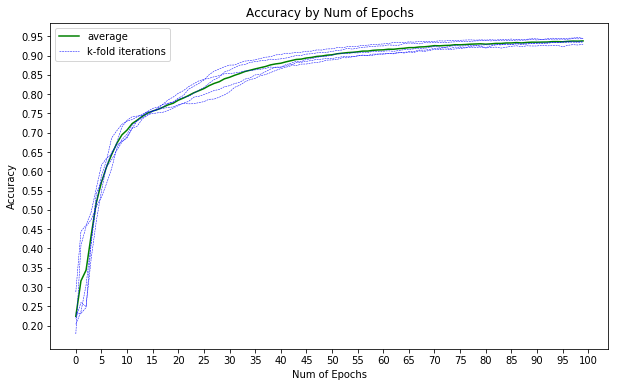

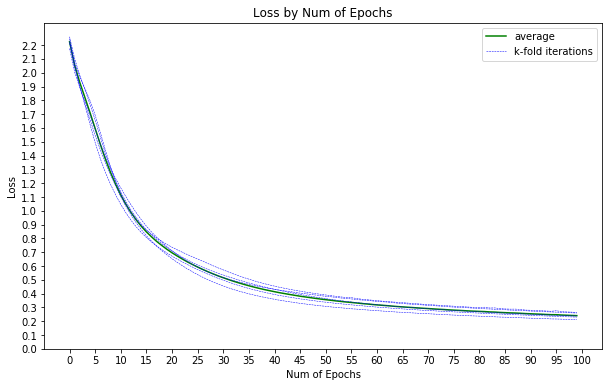

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

def plotAccuracy(results):
    plt.figure(0)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['acc']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['acc'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.2, 1.0, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")
    
    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['loss']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['loss'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0, 2.3, 0.1))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")
    
    plt.show()
    

plotAccuracy(historyList)
plotLoss(historyList)


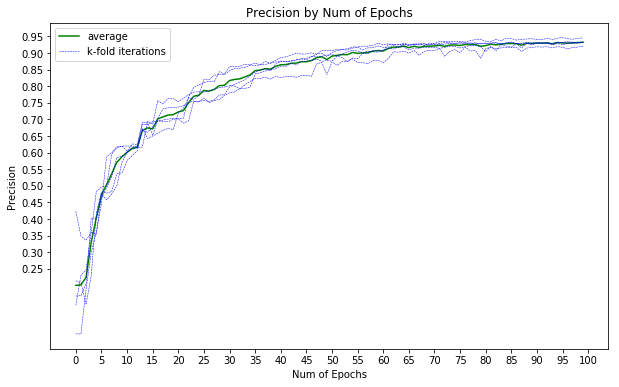

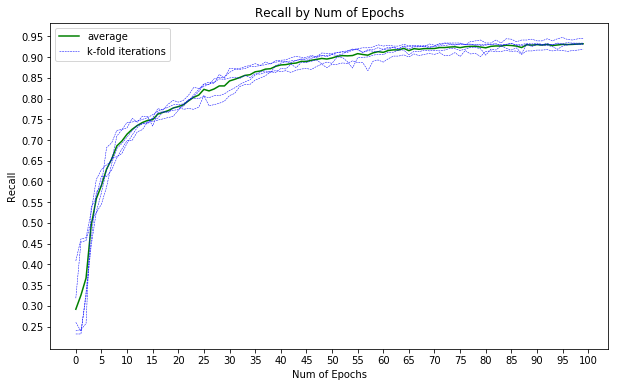

In [130]:
def plotPrecision(metrics):
    plt.figure(2)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_precisions
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_precisions, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
       
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Precision")
    plt.title("Precision by Num of Epochs")
    
    plt.show()
        
def plotRecall(metrics):
    plt.figure(3)
        
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_recalls
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_recalls, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
    
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Recall")
    plt.title("Recall by Num of Epochs")
    plt.show()
    
plotPrecision(metrics)
plotRecall(metrics)
    
    

<Figure size 720x432 with 0 Axes>

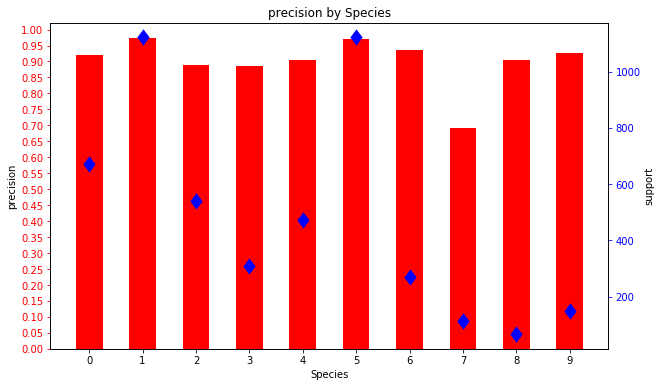

<Figure size 720x432 with 0 Axes>

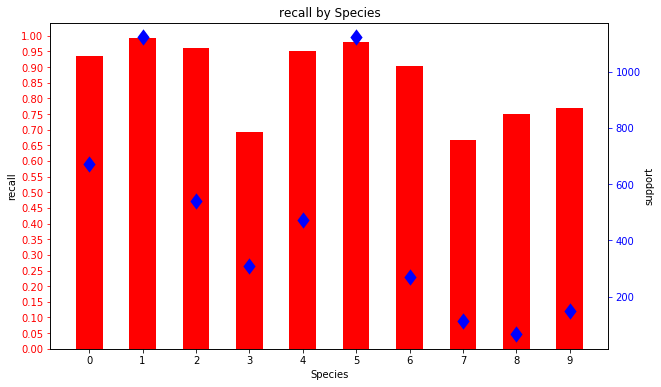

In [131]:
def plotMetricByFeature(values, metric):
    plt.figure(4)
    
    fig, ax1 = plt.subplots()
    
    sum = np.zeros(10) #Number of features (species)
    supportSum = np.zeros(10) #Number of features (species)
    
    for val in values:
        sum += val[metric]
        supportSum += val['support']
        
    avgPrecision = sum / 5 # Number of folds
    
    plt.xticks(np.arange(0, 10, 1.0))
    plt.yticks(np.arange(0, 1.1, 0.05))
    
    ax1.set_xlabel("Species")
    ax1.set_ylabel(metric)
    ax1.tick_params('y', colors='r')
    
    plt.title(metric + " by Species") 
    
    for index, val in enumerate(avgPrecision):
        ax1.bar(index, val, width=0.5, color='red')
        
    ax2 = ax1.twinx()
    for index, val in enumerate(supportSum):
        ax2.plot(index, val, 'db', mew='5')
        
    ax2.set_ylabel('support')
    ax2.tick_params('y', colors='b')
        
    plt.show()
    
plotMetricByFeature(featuresMetrics, 'precision')
plotMetricByFeature(featuresMetrics, 'recall')

    
